# # Intelligent Academic Advisor System
# ## Optimization-Based Course Recommendation with ML Risk Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add src to path
sys.path.append('.')

# Import our modules
from src.data_loader import DataLoader
from src.risk_predictor import CourseFailurePredictor
from src.optimizer import CourseOptimizer
from src.multi_semester_planner import MultiSemesterPlanner
from src.evaluator import AdvisorEvaluator
from src.explanation_generator import ExplanationGenerator

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
print("📂 Loading academic data...\n")

loader = DataLoader("data")
loader.load_all()

courses = loader.courses
prereqs = loader.prereqs
students = loader.students
student_courses = loader.student_courses
rules = loader.rules
G = loader.prereq_graph
rules_dict = loader.get_rules_dict()

print(f"\n📊 Data Summary:")
print(f"   • Total Courses: {len(courses)}")
print(f"   • Total Students: {len(students)}")
print(f"   • Prerequisite Links: {len(prereqs)}")
print(f"   • Academic Rules: {len(rules)}")

# Quick preview
display(courses.head())

📂 Loading academic data...

📂 Loading data files...
✅ Data loaded successfully!
   • Courses: 26
   • Students: 4
   • Prerequisites: 21

📊 Data Summary:
   • Total Courses: 26
   • Total Students: 4
   • Prerequisite Links: 21
   • Academic Rules: 6


,course_code,course_name,credits,difficulty,category,semester
0,CS111,Programming Fundamentals,4,3,Computing Core,1
1,CS112,Object Oriented Programming,4,4,Computing Core,2
2,EE123,Digital Logic Design,3,4,Computing Core,2
3,CS130,Database Systems,4,4,Computing Core,3
4,CS216,Data Structures,4,5,Computing Core,3


🔗 Visualizing prerequisite dependencies...



C:\Users\Hp\AppData\Local\Temp\ipykernel_21748\1266033985.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


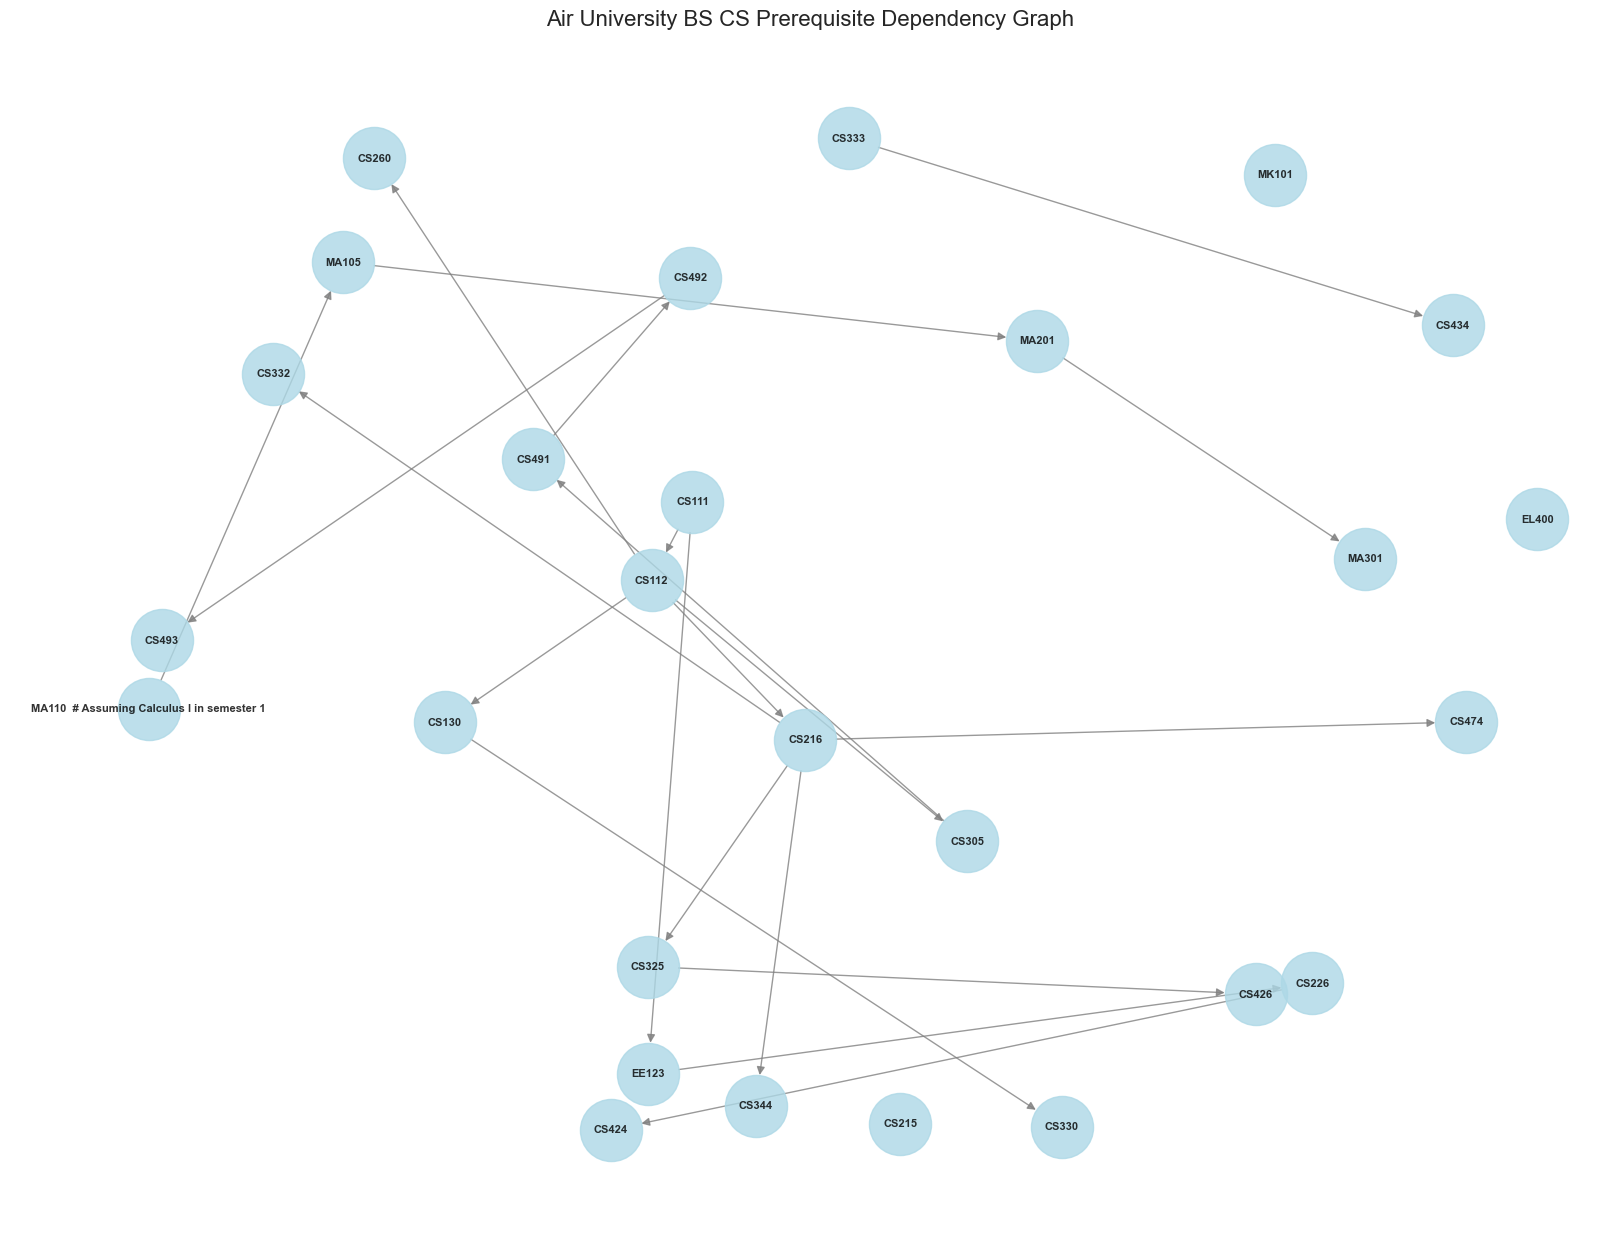

In [3]:
print("🔗 Visualizing prerequisite dependencies...\n")

plt.figure(figsize=(16, 12))
import networkx as nx

pos = nx.spring_layout(G, k=1.0, iterations=50, seed=42)
nx.draw(G, pos, 
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        font_size=8,
        font_weight='bold',
        arrowsize=12,
        edge_color='gray',
        alpha=0.8)

plt.title("Air University BS CS Prerequisite Dependency Graph", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
print("🎓 Training Machine Learning Risk Predictor...\n")

risk_model = CourseFailurePredictor()
risk_model.train(students, student_courses, courses, G)

# Save the trained model
risk_model.save("models/risk_predictor.pkl")

print("\n💾 Model saved to models/risk_predictor.pkl")


🎓 Training Machine Learning Risk Predictor...

🔨 Generating training data from student history...
✅ Generated 18 training samples
🎓 Training risk prediction model...
✅ Model trained successfully!
   • Training MAE: 0.006
   • Samples: 18
💾 Model saved to models\risk_predictor.pkl

💾 Model saved to models/risk_predictor.pkl


In [5]:
print("⚙️ Initializing system components...\n")

optimizer = CourseOptimizer(rules_dict)
planner = MultiSemesterPlanner(courses, G, rules_dict)
evaluator = AdvisorEvaluator(courses, rules_dict)
explainer = ExplanationGenerator()

print("✅ All components initialized!\n")

⚙️ Initializing system components...

✅ All components initialized!



In [6]:
# List all students
print("👥 Available Students:\n")
for i, row in students.iterrows():
    print(f"{i+1}. {row['student_id']} - CGPA: {row['cgpa']:.2f}, Semester: {row['current_semester']}")

# Select a student (change this to test different students)
selected_student_id = "CS2025-001"  # Change this!

print(f"\n✨ Selected: {selected_student_id}\n")

# Get student profile
student_profile = loader.get_student_profile(selected_student_id)

print(f"📋 Student Profile:")
print(f"   • Student ID: {student_profile['student_id']}")
print(f"   • CGPA: {student_profile['student']['cgpa']:.2f}")
print(f"   • Current Semester: {student_profile['student']['current_semester']}")
print(f"   • Completed Courses: {len(student_profile['completed_courses'])}")
print(f"   • Backlogs: {len(student_profile['backlogs'])}")
if student_profile['backlogs']:
    print(f"      → {sorted(student_profile['backlogs'])}")


👥 Available Students:

1. CS2025-001 - CGPA: 2.65, Semester: 4
2. CS2025-002 - CGPA: 3.45, Semester: 5
3. CS2025-003 - CGPA: 2.10, Semester: 3
4. CS2025-004 - CGPA: 3.80, Semester: 6

✨ Selected: CS2025-001

📋 Student Profile:
   • Student ID: CS2025-001
   • CGPA: 2.65
   • Current Semester: 4
   • Completed Courses: 5
   • Backlogs: 1
      → ['CS216']


In [7]:
next_semester = student_profile['student']['current_semester'] + 1

eligible_df = loader.get_eligible_courses(
    student_profile['completed_courses'],
    next_semester,
    student_profile['backlogs']
)

print(f"\n📚 Eligible Courses for Semester {next_semester}: {len(eligible_df)}")
if not eligible_df.empty:
    display(eligible_df[['course_code', 'course_name', 'credits', 'difficulty', 'semester']].head(10))



📚 Eligible Courses for Semester 5: 6


,course_code,course_name,credits,difficulty,semester
0,CS216,Data Structures,4,5,3
1,CS325,Operating Systems,3,5,5
2,CS332,Design and Analysis of Algorithms,3,5,5
3,CS305,Software Engineering,3,4,5
4,CS330,Advanced Database Systems,3,4,5
5,EL400,Technical and Business Writing,3,2,5


In [8]:
print("\n🔮 Predicting failure risk for eligible courses...\n")

risk_scores = risk_model.predict_batch(
    eligible_df,
    student_profile,
    G,
    next_semester
)

# Add risk to eligible courses
eligible_df_with_risk = eligible_df.copy()
eligible_df_with_risk['risk_score'] = eligible_df_with_risk['course_code'].map(risk_scores)

# Show highest risk courses
print("⚠️ Highest Risk Courses:")
high_risk = eligible_df_with_risk.nlargest(5, 'risk_score')[
    ['course_code', 'course_name', 'difficulty', 'risk_score']
]
display(high_risk)



🔮 Predicting failure risk for eligible courses...

⚠️ Highest Risk Courses:


C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X d

,course_code,course_name,difficulty,risk_score
1,CS325,Operating Systems,5,0.689660
2,CS332,Design and Analysis of Algorithms,5,0.689660
4,CS330,Advanced Database Systems,4,0.682886
0,CS216,Data Structures,5,0.424788
3,CS305,Software Engineering,4,0.260605


In [9]:
print("\n🎯 Generating Optimal Course Recommendation...\n")

recommended_df, metadata = optimizer.recommend(
    eligible_df,
    student_profile,
    risk_scores=risk_scores
)

if recommended_df.empty:
    print("❌ No recommendation could be generated!")
    print(f"Status: {metadata.get('status', 'unknown')}")
else:
    print("✅ Recommendation generated successfully!\n")
    
    # Generate full report
    report = explainer.generate_full_report(
        recommended_df,
        student_profile,
        metadata
    )
    
    print(report)



🎯 Generating Optimal Course Recommendation...

✅ Recommendation generated successfully!

🎯 RECOMMENDATION SUMMARY FOR CS2025-001
Student Status: Satisfactory (CGPA: 2.65)
Current Semester: 4
Backlogs: 1 course(s)

📚 RECOMMENDED LOAD:
   • Total Credits: 10/18
   • Number of Courses: 3
   • Backlogs Cleared: 1

📊 WORKLOAD ANALYSIS:
   • Average Difficulty: 3.7/10
   • Risk Level: Low (25.0%)

💡 STRATEGIC ADVICE:
   • Attend office hours if you're struggling with any course
   • Review material regularly, don't wait until exams


📋 DETAILED COURSE BREAKDOWN:

+--------+--------------------------------+-----------+-----------------+--------+-----------------------------------------+----------------------------------------+
| Code   | Course Name                    |   Credits | Difficulty      | Risk   | Reason                                  | Advice                                 |
+========+================================+===========+=================+========+=====================


📊 COMPARING WITH BASELINE METHODS


📊 RECOMMENDATION QUALITY COMPARISON
+----------------------+-----------------+---------------+--------------------+-----------------------+------------------+------------+------------------+-----------------+--------+
|                      |   total_credits |   num_courses |   backlogs_cleared |   low_grades_improved |   avg_difficulty |   avg_risk |   workload_score |   quality_score |   rank |
+======================+=================+===============+====================+=======================+==================+============+==================+=================+========+
| Greedy (Easiest)     |           16.00 |          5.00 |               1.00 |                  1.00 |             4.00 |       0.42 |            65.00 |           24.00 |   1.00 |
+----------------------+-----------------+---------------+--------------------+-----------------------+------------------+------------+------------------+-----------------+--------+
| Our System     

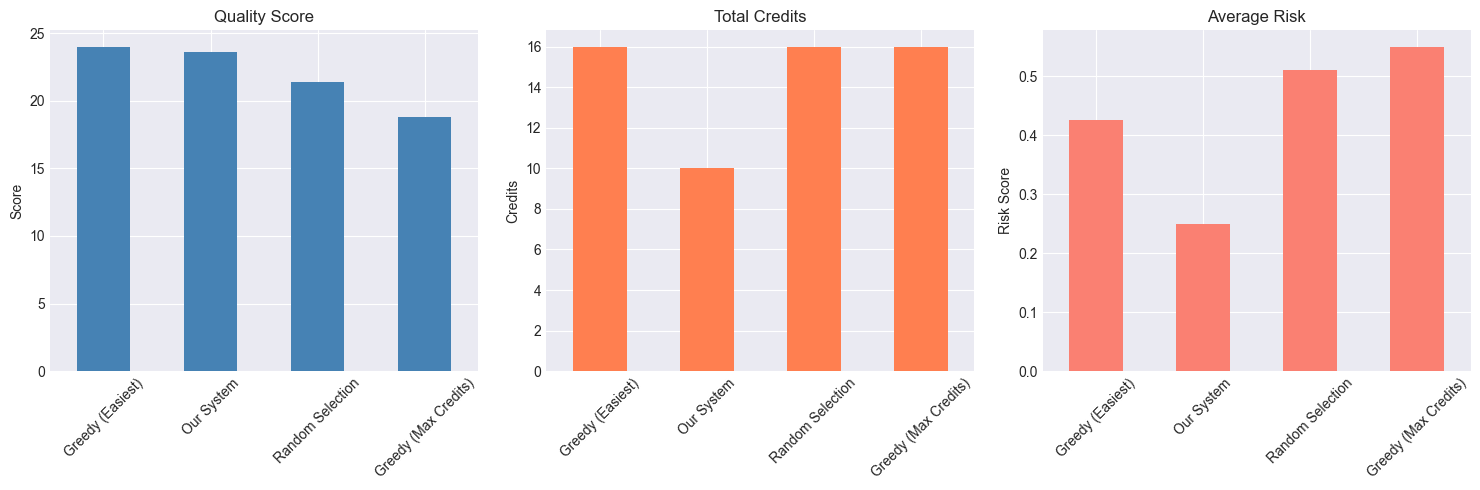

In [10]:
if not recommended_df.empty:
    print("\n" + "="*70)
    print("📊 COMPARING WITH BASELINE METHODS")
    print("="*70 + "\n")
    
    comparison_df = evaluator.compare_methods(
        eligible_df,
        recommended_df['course_code'].tolist(),
        student_profile,
        metadata['max_credits'],
        risk_scores
    )
    
    evaluator.print_comparison_report(comparison_df)
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Quality score comparison
    comparison_df['quality_score'].plot(kind='bar', ax=axes[0], color='steelblue')
    axes[0].set_title('Quality Score')
    axes[0].set_ylabel('Score')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Credits comparison
    comparison_df['total_credits'].plot(kind='bar', ax=axes[1], color='coral')
    axes[1].set_title('Total Credits')
    axes[1].set_ylabel('Credits')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Risk comparison
    comparison_df['avg_risk'].plot(kind='bar', ax=axes[2], color='salmon')
    axes[2].set_title('Average Risk')
    axes[2].set_ylabel('Risk Score')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


In [11]:
if not recommended_df.empty:
    print("\n" + "="*70)
    print("🗓️ MULTI-SEMESTER GRADUATION PATH")
    print("="*70 + "\n")
    
    # Generate 4-semester plan
    future_plan = planner.plan_graduation_path(
        student_profile,
        student_profile['completed_courses'],
        num_semesters=4,
        risk_predictor=risk_model
    )
    
    # Estimate graduation
    grad_semester = planner.estimate_graduation_semester(
        student_profile,
        student_profile['completed_courses']
    )
    
    print(f"🎓 Estimated Graduation: Semester {grad_semester}\n")
    
    # Display plan
    for i, plan in enumerate(future_plan, 1):
        print(f"\n📅 Semester {plan['semester']} ({plan['total_credits']} credits):")
        if plan['courses']:
            for code in plan['courses'][:5]:  # Show first 5
                course_name = courses[courses['course_code'] == code]['course_name'].values[0]
                print(f"   • {code}: {course_name}")
            if len(plan['courses']) > 5:
                print(f"   ... and {len(plan['courses']) - 5} more courses")
        else:
            print(f"   {plan.get('note', 'No courses planned')}")
    
    # Progress visualization
    progress = planner.calculate_progress_percentage(student_profile['completed_courses'])
    
    print(f"\n📊 Degree Progress:")
    print(f"   • Credits Completed: {progress['total_credits_completed']}/{progress['total_credits_required']}")
    print(f"   • Percentage Complete: {progress['percentage_complete']:.1f}%")
    print(f"   • Credits Remaining: {progress['credits_remaining']}")


🗓️ MULTI-SEMESTER GRADUATION PATH

🎓 Estimated Graduation: Semester 8


📅 Semester 5 (18 credits):
   • CS215: Information Security
   • EL400: Technical and Business Writing
   • CS305: Software Engineering
   • CS330: Advanced Database Systems
   • CS260: Computer Networks
   ... and 1 more courses

📅 Semester 6 (16 credits):
   • MK101: Principles of Marketing
   • CS344: Artificial Intelligence
   • CS491: Final Year Project I
   • CS333: Theory of Automata
   • CS226: Computer Organization and Assembly Language
   ... and 1 more courses

📅 Semester 7 (14 credits):
   • CS474: HCI & Computer Graphics
   • CS492: Final Year Project II
   • CS434: Compiler Construction
   • CS424: Computer Architecture
   • CS426: Parallel and Distributed Computing

📅 Semester 8 (3 credits):
   • CS493: Final Year Project III

📊 Degree Progress:
   • Credits Completed: 19/137
   • Percentage Complete: 13.9%
   • Credits Remaining: 118


C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X d

In [12]:
if not recommended_df.empty:
    print("\n" + "="*70)
    print("🔀 ALTERNATIVE RECOMMENDATIONS")
    print("="*70 + "\n")
    
    alternatives = optimizer.generate_alternatives(
        eligible_df,
        student_profile,
        risk_scores,
        num_alternatives=3
    )
    
    for i, (alt_rec, alt_meta) in enumerate(alternatives, 1):
        print(f"\n{'='*60}")
        print(f"Option {i}: {alt_meta['profile']}")
        print(f"{'='*60}")
        print(f"Credits: {alt_meta['total_credits']}, Risk: {alt_meta['avg_risk']:.1%}")
        print(f"Courses:")
        for _, course in alt_rec.iterrows():
            print(f"   • {course['course_code']}: {course['course_name']}")



🔀 ALTERNATIVE RECOMMENDATIONS


Option 1: Balanced
Credits: 10, Risk: 25.0%
Courses:
   • CS216: Data Structures
   • CS305: Software Engineering
   • EL400: Technical and Business Writing

Option 2: Conservative (Lower Risk)
Credits: 7, Risk: 24.5%
Courses:
   • CS216: Data Structures
   • EL400: Technical and Business Writing

Option 3: Aggressive (Max Progress)
Credits: 16, Risk: 42.5%
Courses:
   • CS216: Data Structures
   • CS325: Operating Systems
   • CS305: Software Engineering
   • CS330: Advanced Database Systems
   • EL400: Technical and Business Writing


In [13]:
print("\n" + "="*70)
print("📈 SYSTEM PERFORMANCE ACROSS ALL STUDENTS")
print("="*70 + "\n")

def get_recommendation_for_student(student_profile):
    next_sem = student_profile['student']['current_semester'] + 1

    eligible = loader.get_eligible_courses(
        student_profile['completed_courses'],
        next_sem,
        student_profile['backlogs']
    )

    if eligible.empty:
        return pd.DataFrame(), {
            'status': 'no_eligible',
            'total_credits': 0,
            'avg_risk': 0.0,
            'history': []
        }

    risks = risk_model.predict_batch(eligible, student_profile, G, next_sem)

    rec_df, metrics = optimizer.recommend(
        eligible,
        student_profile,
        risks
    )

    # 🔴 GUARANTEE keys exist
    metrics.setdefault('history', [])
    metrics.setdefault('avg_risk', 0.0)
    metrics.setdefault('total_credits', 0)

    return rec_df, metrics

# Run batch evaluation
batch_results = evaluator.batch_evaluate(
    students,
    get_recommendation_for_student,
    student_courses,
    courses,
    G
)

print("Batch Evaluation Results:\n")
display(batch_results)

# Summary statistics
print(f"\n📊 Summary Statistics:")
successful = batch_results[batch_results['status'] == 'success']

if not successful.empty:
    print(f"   • Average Credits Recommended: {successful['recommended_credits'].mean():.1f}")
    print(f"   • Average Risk: {successful['avg_risk'].mean():.2%}")
else:
    print("   • No successful recommendations to analyze")
print(f"   • Average Risk: {batch_results['avg_risk'].mean():.2%}")
print(f"   • Students with Backlogs: {(batch_results['backlogs_count'] > 0).sum()}")

# Plot CGPA vs recommended credits
plt.figure(figsize=(10, 6))
plt.scatter(batch_results['cgpa'], batch_results['recommended_credits'], 
           s=100, alpha=0.6, c=batch_results['backlogs_count'], cmap='Reds')
plt.xlabel('Student CGPA')
plt.ylabel('Recommended Credits')
plt.title('Recommended Credits vs CGPA (color = number of backlogs)')
plt.colorbar(label='Backlogs')
plt.grid(True, alpha=0.3)
plt.show()



📈 SYSTEM PERFORMANCE ACROSS ALL STUDENTS

Batch Evaluation Results:



,student_id,cgpa,semester,status
0,CS2025-001,2.65,4,error: 'history'
1,CS2025-002,3.45,5,error: 'history'
2,CS2025-003,2.10,3,error: 'history'
3,CS2025-004,3.80,6,error: 'history'



📊 Summary Statistics:
   • No successful recommendations to analyze


KeyError: 'avg_risk'

In [ ]:
if not recommended_df.empty:
    print("\n💾 Exporting recommendation to CSV...")
    
    # Create output directory
    Path("output").mkdir(exist_ok=True)
    
    # Export recommendation
    output_file = f"output/recommendation_{selected_student_id}_sem{next_semester}.csv"
    recommended_df.to_csv(output_file, index=False)
    
    print(f"✅ Saved to: {output_file}")
    
    # Also save the full report as text
    report_file = f"output/report_{selected_student_id}_sem{next_semester}.txt"
    with open(report_file, 'w') as f:
        f.write(explainer.generate_full_report(
            recommended_df, student_profile, metadata, comparison_df
        ))
    
    print(f"✅ Report saved to: {report_file}")




# ## Summary
# 
# This notebook demonstrates:
# 1. ✅ ML-based risk prediction
# 2. ✅ Optimization-based course selection
# 3. ✅ Multi-semester graduation planning
# 4. ✅ Baseline comparison & evaluation
# 5. ✅ Explainable recommendations
# 
# **Next Steps:**
# - Run CLI: `python advisor_cli.py`
# - Adjust student selection in Cell 6
# - Experiment with different weight profiles
# - Add more students to CSV files


In [ ]:
print("\n" + "="*70)
print("✅ NOTEBOOK COMPLETE!")
print("="*70)